In [3]:
import pandas as pd

# Load the CSV files
file1 = '../data/nb.csv'
file2 = '../data/driver_locations_during_request.csv'

data1 = pd.read_csv(file1)
data2 = pd.read_csv(file2)

# Print info about the data
print(data1.info())
print(data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536020 entries, 0 to 536019
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Trip ID            536020 non-null  int64  
 1   Trip Origin        536020 non-null  object 
 2   Trip Destination   536020 non-null  object 
 3   Trip Start Time    536020 non-null  object 
 4   Trip End Time      536020 non-null  object 
 5   Hour of the Day    536020 non-null  int64  
 6   Weekend            536020 non-null  object 
 7   Trip Duration      536020 non-null  float64
 8   Origin_Lat         536020 non-null  float64
 9   Origin_Lon         536020 non-null  float64
 10  Destination_Lat    536020 non-null  float64
 11  Destination_Lon    536020 non-null  float64
 12  Distance_KM        536020 non-null  float64
 13  Duration_Hours     536020 non-null  float64
 14  Driving_Speed_KMH  536020 non-null  float64
dtypes: float64(8), int64(2), object(5)
memory usage: 61

In [4]:
# Check for missing data
print(data1.isnull().sum())

Trip ID              0
Trip Origin          0
Trip Destination     0
Trip Start Time      0
Trip End Time        0
Hour of the Day      0
Weekend              0
Trip Duration        0
Origin_Lat           0
Origin_Lon           0
Destination_Lat      0
Destination_Lon      0
Distance_KM          0
Duration_Hours       0
Driving_Speed_KMH    0
dtype: int64


In [5]:
print(data2.isnull().sum())

id               0
order_id         0
driver_id        0
driver_action    0
lat              0
lng              0
dtype: int64


In [6]:
# Convert 'Trip Start Time' to datetime format
data1['Trip Start Time'] = pd.to_datetime(data1['Trip Start Time'], errors='coerce')

# Fill missing values in 'Trip Start Time' with the median
data1['Trip Start Time'] = data1['Trip Start Time'].fillna(data1['Trip Start Time'].median())


In [7]:
# Print after filling the missing values
print(data1.isnull().sum())

Trip ID              0
Trip Origin          0
Trip Destination     0
Trip Start Time      0
Trip End Time        0
Hour of the Day      0
Weekend              0
Trip Duration        0
Origin_Lat           0
Origin_Lon           0
Destination_Lat      0
Destination_Lon      0
Distance_KM          0
Duration_Hours       0
Driving_Speed_KMH    0
dtype: int64


In [8]:
# Convert 'Trip End Time' to datetime format
data1['Trip End Time'] = pd.to_datetime(data1['Trip End Time'], errors='coerce')

# Fill missing values in 'Trip End Time' with the median
data1['Trip End Time'] = data1['Trip End Time'].fillna(data1['Trip End Time'].median())


In [9]:
# Print after filling the missing values
print(data1.isnull().sum())

Trip ID              0
Trip Origin          0
Trip Destination     0
Trip Start Time      0
Trip End Time        0
Hour of the Day      0
Weekend              0
Trip Duration        0
Origin_Lat           0
Origin_Lon           0
Destination_Lat      0
Destination_Lon      0
Distance_KM          0
Duration_Hours       0
Driving_Speed_KMH    0
dtype: int64


In [10]:
# Save the updated data to the same CSV files (overwriting them)
data1.to_csv(file1, index=False)
data2.to_csv(file2, index=False)

In [11]:
# Function to check if a date is a holiday
import requests


def is_holiday(date):
    api_key = '0WE53kty7QlnXgxu8hmnJouukwkxyiKz'
    url = f'https://calendarific.com/api/v2/holidays'
    params = {
        'api_key': api_key,
        'country': 'NG',
        'year': date.year,
        'month': date.month,
        'day': date.day
    }
    response = requests.get(url, params=params)
    holiday_data = response.json()
    holidays = holiday_data.get('response', {}).get('holidays', [])
    return 1 if holidays else 0


In [12]:
data1['Hour of the Day'] = data1['Trip Start Time'].dt.hour
data1['Weekend'] = data1['Trip Start Time'].dt.dayofweek.apply(lambda x: "Weekend" if x >= 5 else "Weekdays")

In [13]:
# Extract trip duration in minutes
data1['Trip Duration'] = (data1['Trip End Time'] - data1['Trip Start Time']).dt.total_seconds() / 60.0

In [14]:
data1.to_csv(file1, index=False)

In [15]:
import numpy as np

# Constants
EARTH_RADIUS_KM = 6371

data1['Trip Start Time'] = pd.to_datetime(data1['Trip Start Time'])
data1['Trip End Time'] = pd.to_datetime(data1['Trip End Time'])

# Haversine formula to compute the shortest distance between two points
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = EARTH_RADIUS_KM * c
    return distance

In [16]:
# Function to compute driving speed
def compute_speed(distance, duration):
    return distance / duration if duration > 0 else 0

In [17]:
# Using 'Trip Origin' and 'Trip Destination' to obtain coordinates in 'lat,lon' format
data1[['Origin_Lat', 'Origin_Lon']] = data1['Trip Origin'].str.split(',', expand=True).astype(float)
data1[['Destination_Lat', 'Destination_Lon']] = data1['Trip Destination'].str.split(',', expand=True).astype(float)

# Calculate distance using the Haversine formula
data1['Distance_KM'] = data1.apply(lambda row: haversine(row['Origin_Lat'], row['Origin_Lon'], row['Destination_Lat'], row['Destination_Lon']), axis=1)

# Calculate trip duration in hours
data1['Duration_Hours'] = (data1['Trip End Time'] - data1['Trip Start Time']).dt.total_seconds() / 3600

# Compute driving speed
data1['Driving_Speed_KMH'] = data1.apply(lambda row: compute_speed(row['Distance_KM'], row['Duration_Hours']), axis=1)

# Display the updated DataFrame
print(data1.head())


   Trip ID                         Trip Origin  \
0   391996  6.508813001668548,3.37740316890347   
1   391997                 6.4316714,3.4555375   
2   391998         6.631679399999999,3.3388976   
3   391999         6.572757200000001,3.3677082   
4   392001                 6.6010417,3.2766339   

                  Trip Destination     Trip Start Time       Trip End Time  \
0      6.650969799999999,3.3450307 2021-07-01 07:28:04 2021-07-01 07:29:37   
1  6.4280814653326,3.4721885847586 2021-07-01 06:38:04 2021-07-01 07:07:28   
2      6.508324099999999,3.3590397 2021-07-01 06:21:02 2021-07-01 07:02:23   
3      6.584881099999999,3.3614073 2021-07-01 07:16:07 2021-07-01 07:29:42   
4              6.4501069,3.3916154 2021-07-01 09:30:59 2021-07-01 09:34:36   

   Hour of the Day   Weekend  Trip Duration  Origin_Lat  Origin_Lon  \
0                7  Weekdays       1.550000    6.508813    3.377403   
1                6  Weekdays      29.400000    6.431671    3.455538   
2                

In [18]:
data1.to_csv(file1, index=False)

In [20]:
%pip install jupyter_bokeh


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
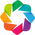

BokehModel(combine_events=True, render_bundle={'docs_json': {'9fa8e39d-1b00-4e0f-86c0-4d0a1dd46fe0': {'version…

In [19]:
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import holoviews as hv
import geoviews as gv
from holoviews.operation.datashader import datashade
from colorcet import fire
hv.extension('bokeh', 'matplotlib')


sampled_data = data1.sample(frac=0.01, random_state=1)

# Define the Points and Paths for visualization
points = hv.Points(sampled_data, ['Origin_Lon', 'Origin_Lat'])

# Creating a path for each trip
paths = hv.Path([[(row['Origin_Lon'], row['Origin_Lat']), 
                  (row['Destination_Lon'], row['Destination_Lat'])] for index, row in sampled_data.iterrows()])

# Visualize points and paths using datashader
shaded_points = datashade(points, cmap=fire, width=800, height=600, normalization='log')
shaded_paths = datashade(paths, cmap=fire, width=800, height=600, normalization='log')

# Combine both visualizations
combined = shaded_points * shaded_paths

# Display the combined visualization
hv.save(combined, 'visualization.html', backend='bokeh')
combined

In [20]:
from sklearn.model_selection import train_test_split

# Split the data into training and hold-out sets
train_data, holdout_data = train_test_split(data1, test_size=0.2, random_state=42)
print(f"Training data shape: {train_data.shape}")
print(f"Holdout data shape: {holdout_data.shape}")

Training data shape: (428816, 15)
Holdout data shape: (107204, 15)


In [21]:
%pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [25]:
%pip install --upgrade causalnex 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [40]:
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
import matplotlib.pyplot as plt
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import networkx as nx

# Select relevant columns for causal analysis
causal_data = train_data[['Trip Start Time', 'Trip End Time', 'Origin_Lat', 'Origin_Lon', 'Destination_Lat', 'Destination_Lon', 'Driving_Speed_KMH']]

# Convert datetime columns to numerical values (e.g., Unix timestamp)
causal_data['Trip Start Time'] = causal_data['Trip Start Time'].apply(lambda x: x.timestamp())
causal_data['Trip End Time'] = causal_data['Trip End Time'].apply(lambda x: x.timestamp())

# Create a causal graph using the Notears algorithm
sm = from_pandas(causal_data)

# Visualize the causal graph
viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

import networkx as nx

# Create an empty NetworkX graph
G_nx = nx.DiGraph()

# Add nodes from the causalnex network
# Add nodes from the causalnex network
for node in viz.nodes:
    node_name = node["label"]
    G_nx.add_node(node_name)

# Add edges from the causalnex network
# Add edges from the causalnex network
for edge in viz.edges:
    source_label = edge[0]["label"]
    target_label = edge[1]["label"]
    G_nx.add_edge(source_label, target_label)


# Display the graph
plt.figure(figsize=(20, 20))
nx.draw(G_nx, with_labels=True)
plt.show()



/tmp/ipykernel_739496/1166775191.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  causal_data['Trip Start Time'] = causal_data['Trip Start Time'].apply(lambda x: x.timestamp())
/tmp/ipykernel_739496/1166775191.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  causal_data['Trip End Time'] = causal_data['Trip End Time'].apply(lambda x: x.timestamp())
/home/melaku/.local/lib/python3.10/site-packages/causalnex/structure/notears.py:436: UserWarning: Failed to converge. Consider increasing max_iter.
  warn

AttributeError: 'list' object has no attribute 'items'

In [36]:
# Print the first node in viz.nodes to inspect its structure
print(viz.nodes[0])


{'color': {'border': '#FFFFFFD9', 'background': '#4a90e2d9'}, 'font': {'color': '#FFFFFF8c', 'face': 'Helvetica', 'size': 25}, 'size': 15, 'borderWidth': 5, 'mass': 1, 'id': 'Trip Start Time', 'label': 'Trip Start Time', 'shape': 'dot'}
